In [1]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torch.nn import functional as F

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d watchman/rtsd-dataset
!unzip rtsd-dataset.zip
!rm rtsd-dataset.zip
!cp -r rtsd-frames/rtsd-frames/ .
!rm -r rtsd-frames/rtsd-frames/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_47_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_53_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_53_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_53_2.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_54_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_54_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_54_2.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_2.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_3.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_56_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!cp chkpt_model2r_d_0.pth /content/drive/MyDrive
!cp chkpt_model2r_d_1.pth /content/drive/MyDrive
!cp chkpt_model2r_d_2.pth /content/drive/MyDrive
!cp chkpt_model2r_d_3.pth /content/drive/MyDrive
!cp chkpt_model2r_d_4.pth /content/drive/MyDrive
!cp chkpt_model2r_d_5.pth /content/drive/MyDrive
!cp chkpt_model2r_d_6.pth /content/drive/MyDrive
!cp chkpt_model2r_d_7.pth /content/drive/MyDrive
!cp chkpt_model2r_d_8.pth /content/drive/MyDrive
!cp chkpt_model2r_d_9.pth /content/drive/MyDrive
!cp chkpt_m2r_d_0.pth /content/drive/MyDrive
!cp chkpt_m2r_d_1.pth /content/drive/MyDrive
!cp chkpt_m2r_d_2.pth /content/drive/MyDrive
!cp chkpt_m2r_d_3.pth /content/drive/MyDrive
!cp chkpt_m2r_d_4.pth /content/drive/MyDrive
!cp chkpt_m2r_d_5.pth /content/drive/MyDrive
!cp chkpt_m2r_d_6.pth /content/drive/MyDrive
!cp chkpt_m2r_d_7.pth /content/drive/MyDrive
!cp chkpt_m2r_d_8.pth /content/drive/MyDrive
!cp chkpt_m2r_v_9.pth /content/drive/MyDrive

cp: cannot stat 'chkpt_m2r_v_9.pth': No such file or directory


In [50]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

n_epochs = 10
batch_size = 6
classes = 2
classes1 = 156
device

'cpu'

In [4]:
def anno_1_class(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'rtsd'}]
    
    anno_file_new = anno_file.split('.')[0] + '_1.json'
    
    with open(os.path.join('.', anno_file_new), 'w') as f:
        json.dump(anno_json, f)
    f.close()

    return anno_json

In [5]:
def anno_train_test_split(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as file1:
        anno_json1 = json.load(file1)
    
    x1 = int(len(anno_json1['images'])*0.2)
    file_train = anno_file.split('.')[0] + '_train.json'
          
    del anno_json1['images'][:x1]
    
    with open(os.path.join('.', file_train), 'w') as f1:
                        json.dump(anno_json1, f1)
    
    
    with open(os.path.join('.', anno_file), 'r') as file2:
            anno_json2 = json.load(file2)
    
    
    x2 = int(len(anno_json2['images'])*0.2)
    y2 = int(len(anno_json2['images']))
    
    file_test= anno_file.split('.')[0] + '_test.json'
    
    del anno_json2['images'][x2:y2]
            
    with open(os.path.join('.', file_test), 'w') as f2:
                        json.dump(anno_json2, f2)  
            
    return anno_json1, anno_json2

In [6]:
train_anno_1 = anno_1_class('train_anno.json')
val_anno_1 = anno_1_class('val_anno.json')
train_anno_reduced_1 = anno_1_class('train_anno_reduced.json')

In [7]:
train1, test1 = anno_train_test_split('train_anno_1.json')

In [8]:
class RTSD_dataset_coco(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
    
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        
        img = img/255
    
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)

In [9]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [10]:
def get_transform_a():
             return transforms.Compose([transforms.Resize((512,512)),
                    transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(), transforms.ToTensor()]),
                    transforms.Compose([transforms.ColorJitter(), transforms.ToTensor()]),
                    transforms.Compose([transforms.RandomResizedCrop((512,512)),transforms.ToTensor()]),
                    transforms.Compose([transforms.ToTensor(),transforms.RandomErasing()])])])

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df1 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df1.__getitem__(100)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [13]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df11 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df11.__getitem__(100)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [14]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df2 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform_a()
                          )
# df2.__getitem__(100)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [15]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df22 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform_a()
                          )
# df22.__getitem__(100)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [16]:
data_loader_train1 = torch.utils.data.DataLoader(df1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_train2 = torch.utils.data.DataLoader(df2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

data_loader_val1 = torch.utils.data.DataLoader(df11,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val2 = torch.utils.data.DataLoader(df22,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [17]:
def show_tranformed_image(train_loader):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
            sample = sample * 255
            ax.imshow(sample)
            for box in boxes:
                      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
                      rect = patches.Rectangle((x, y),
                                              width, height,
                                              fc ='none', 
                                              ec ='g',
                                              lw = 2)
                      ax.add_patch(rect)
            plt.axis('off')
            plt.show()

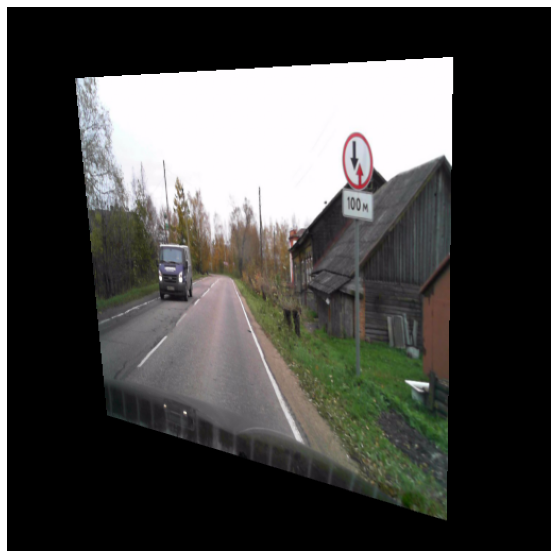

In [18]:
show_tranformed_image(data_loader_train2)

In [ ]:
# dir(models.detection.faster_rcnn)

In [19]:
def build_model(n_model, classes):
    if 'resnet50_fpn_v2' in n_model:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    elif 'resnet50_fpn' in n_model:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    else:
        print("нет такой модели ")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
    
    return model

In [ ]:
# def load_ckp(checkpoint_fpath, model, optimizer):
#     """
#     checkpoint_path: path to save checkpoint
#     model: model that we want to load checkpoint parameters into       
#     optimizer: optimizer we defined in previous training
#     """
#     # load check point
#     checkpoint = torch.load(checkpoint_fpath, map_location=device)
#     # initialize state_dict from checkpoint to model
#     model.load_state_dict(checkpoint['model_state_dict'])
#     # initialize optimizer from checkpoint to optimizer
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     # initialize valid_loss_min from checkpoint to valid_loss_min
#     valid_loss_min = checkpoint['loss_val']
#     # return model, optimizer, epoch value, min validation loss 
#     return model, optimizer, checkpoint['epoch'], valid_loss_min

# model = build_model('resnet50_fpn_v2', 2).to(device)
# params1 = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params1)

# model1, optimizer1, start_epoch, loss1_val = load_ckp('./chkpt_model1r_d_7.pth', model, optimizer)

In [ ]:
# def load_ckp1(checkpoint_fpath, model):
#     """
#     checkpoint_path: path to save checkpoint
#     model: model that we want to load checkpoint parameters into       
#     optimizer: optimizer we defined in previous training
#     """
#     # load check point
#     checkpoint = torch.load(checkpoint_fpath, map_location=device)
#     # initialize state_dict from checkpoint to model
#     model.load_state_dict(checkpoint)
    
#     return model

# model = build_model('resnet50_fpn_v2', 2).to(device)
# params1 = [p for p in model.parameters() if p.requires_grad]
# optimizer1 = torch.optim.Adam(params1)

# model1 = load_ckp1('./chkpt_model1_dr_7.pth', model)

In [20]:
model1 = build_model('resnet50_fpn', 2).to(device)
params1 = [p for p in model1.parameters() if p.requires_grad]
optimizer1 = torch.optim.Adam(params1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [23]:
loss1_train = []
loss1_val = []

for epoch in range(n_epochs):
    start = time.time()
    model1.train()
    for i, batch in enumerate(data_loader_train1):
        optimizer1.zero_grad()
        loss_train = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model1(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_train += losses.item()
        losses.backward()
        optimizer1.step()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_train = (loss_train / i)
    loss1_train.append(loss11_train)
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', (loss_train / i))
    
    for i, batch in enumerate(data_loader_val1):
        optimizer1.zero_grad()
        loss_val = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
              loss_dict = model1(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_val += losses.item()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_val = (loss_val / i)
    loss1_val.append(loss11_val)
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', (loss_val / i))
    
        
    torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'optimizer_state_dict': optimizer1.state_dict(),
                    'loss_train': loss1_train,
                    'loss_val': loss1_val,
                    }, f'./chkpt_model2r_d_{epoch}.pth')
    
    torch.save(model1.state_dict(), f'./chkpt_m2r_d_{epoch}.pth')


epoch: 0, step: 0, loss: 1.3739720582962036
epoch: 0, step: 200, loss: 0.14472851157188416
Эпоха train: 0 Итераций: 313 train loss: 0.033760917834199655
epoch: 0, step: 0, loss: 55.638797760009766
epoch: 0, step: 200, loss: 48.42886734008789
epoch: 0, step: 400, loss: 132.6119384765625
epoch: 0, step: 600, loss: 41.11486053466797
epoch: 0, step: 800, loss: 83.50145721435547
Потрачено 20.2 минут на 0 эпоху
Эпоха val: 0 Итераций: 832 val loss: 0.047403619839594915
epoch: 1, step: 0, loss: 35.208778381347656
epoch: 1, step: 200, loss: 1.3430699110031128
Эпоха train: 1 Итераций: 313 train loss: 0.001828766478517185
epoch: 1, step: 0, loss: 0.7169287800788879
epoch: 1, step: 200, loss: 1.4180946350097656
epoch: 1, step: 400, loss: 1.7774434089660645
epoch: 1, step: 600, loss: 0.7238799333572388
epoch: 1, step: 800, loss: 1.5068384408950806
Потрачено 20.1 минут на 1 эпоху
Эпоха val: 1 Итераций: 832 val loss: 0.0004787920401073419
epoch: 2, step: 0, loss: 0.5644528269767761
epoch: 2, step: 20

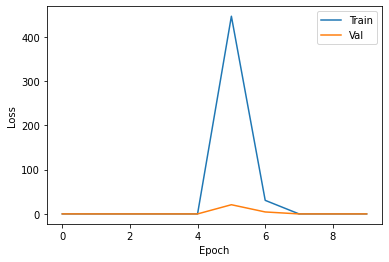

In [39]:
fig, ax  = plt.subplots()
ax.plot(loss1_train, label='Train')
ax.plot(loss1_val, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.savefig("loss1.png")
ax.legend()

In [40]:
transform = transforms.Compose([transforms.ToTensor(),])

In [51]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
device

'cpu'

In [75]:
model_d = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
in_features = model_d.roi_heads.box_predictor.cls_score.in_features
model_d.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
checkpoint = torch.load('chkpt_model2r_d_0.pth', map_location=device)
model_d.load_state_dict(checkpoint['model_state_dict'])
model_d.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [71]:
img_name = '56.jpg'
detection_threshold = 0
image1 = Image.open(img_name)

In [76]:
image = transform(image1).to(device)
image = image.unsqueeze(0) # add a batch dimension
outputs = model_d(image)
pred_classes = [i for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
pred_scores

array([], dtype=float32)

In [69]:
pred_classes

[]

In [70]:
pred_bboxes

array([], shape=(0, 4), dtype=float32)

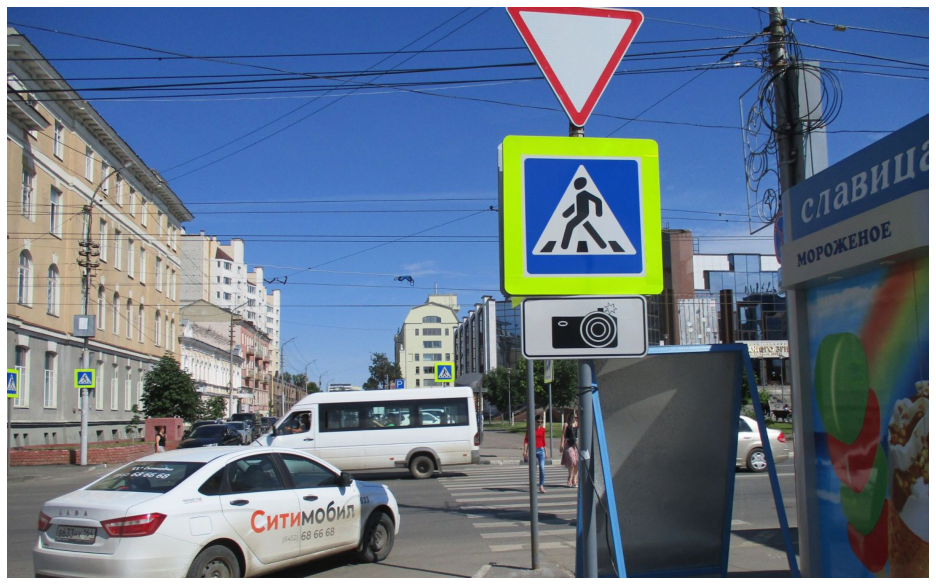

In [74]:
im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
# for i in range(len(boxes)):
#     rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
plt.axis('off')
plt.show()

In [77]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [80]:
df_val = dataset('.', 'val_anno.json')
detection_threshold = 0.2

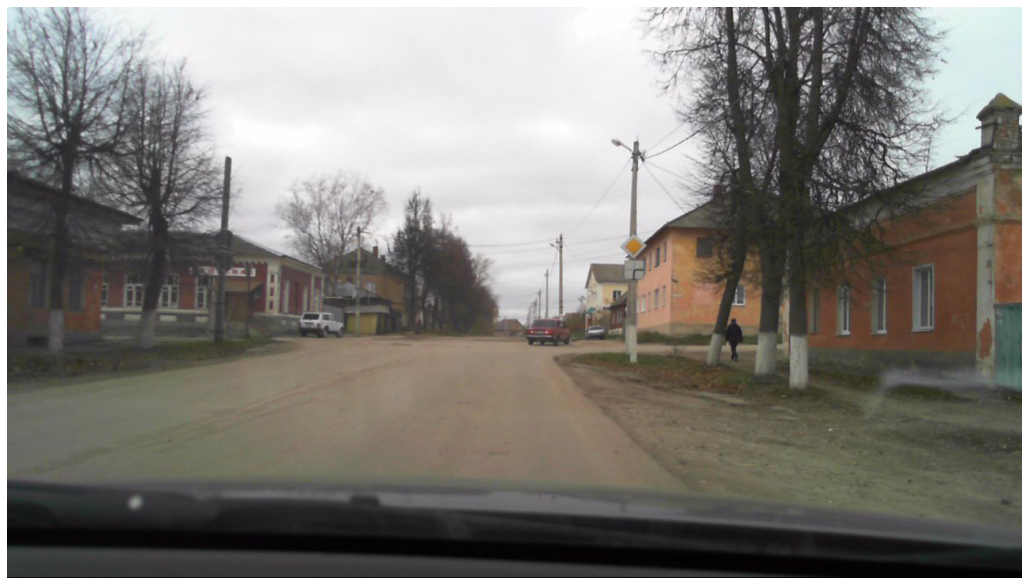

In [82]:
y = np.random.choice(df_val.file_name)
im_labels = df_val[df_val.file_name == y].iloc[0]
im = Image.open('./' + y)
image = transform(im).to(device)
image = image.unsqueeze(0) # add a batch dimension
outputs = model_d(image)
pred_classes = [i for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
pred_scores

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
# for i in range(len(boxes)):
#     rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
plt.axis('off')
plt.show()